# Amazon Review Data

## Data profiling, data visualization, statistical testing, and machine learning

In [ ]:
import torch
import torchtext
from torchvision import io
from torch.utils import data
from torchtext.legacy.data import TabularDataset, Field

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from scipy.stats import t, ttest_ind

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer

sns.set_style('darkgrid')

In [ ]:
!ls /datasets/the-multilingual-amazon-reviews-corpus

dataset_en_dev.json  dataset_en_test.json  dataset_en_train.json


In [ ]:
train = pd.read_json('/datasets/the-multilingual-amazon-reviews-corpus/dataset_en_train.json', lines=True)
test = pd.read_json('/datasets/the-multilingual-amazon-reviews-corpus/dataset_en_test.json', lines=True)
dev = pd.read_json('/datasets/the-multilingual-amazon-reviews-corpus/dataset_en_dev.json', lines=True)

## Exploring the training data

There are 3 files included in the dataset. To get a sense of the data, I will perform some exploratory tasks to explain the dataset better.

In [ ]:
train.head(3)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home


In [ ]:
# Looking at the number of reviews and the mean rating for the individual products
product_summary = train.groupby(['product_id', 'product_category'], as_index=False)\
                        .agg({'review_id':'count','stars':'mean'})\
                        .sort_values('review_id', ascending=False)

# Add the denominator for the weights for the summary stastic of weighted average in the products by category
product_summary['total_categ_reviews'] = product_summary.groupby('product_category')['review_id']\
                                                 .transform(np.sum)

product_summary['weights'] =  product_summary['review_id'] / product_summary['total_categ_reviews']
product_summary = product_summary.rename(columns={'review_id':'review_count', 'stars':'average_stars'})

product_summary

,product_id,product_category,review_count,average_stars,total_categ_reviews,weights
34011,product_en_0184780,home,6,2.833333,17679,0.000339
91250,product_en_0491284,automotive,5,2.800000,7506,0.000666
78050,product_en_0420950,lawn_and_garden,5,2.400000,7327,0.000682
11380,product_en_0061393,other,5,2.400000,13418,0.000373
108271,product_en_0584134,kitchen,5,2.000000,10382,0.000482
...,...,...,...,...,...,...
64109,product_en_0345967,kitchen,1,3.000000,10382,0.000096
64110,product_en_0345972,home,1,1.000000,17679,0.000057
64111,product_en_0345976,toy,1,2.000000,8745,0.000114
64112,product_en_0345977,book,1,3.000000,3756,0.000266


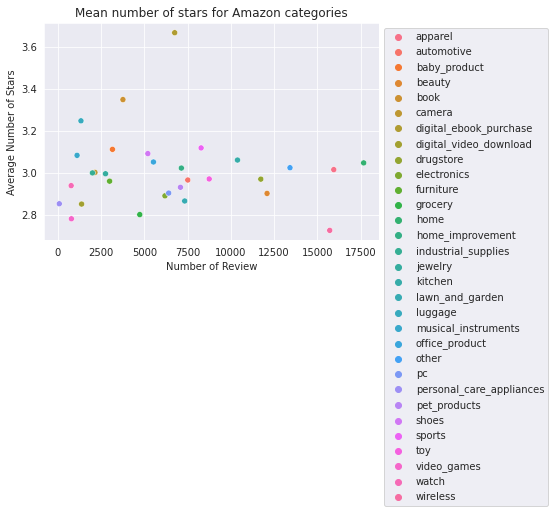

In [ ]:
categories_summary = train.groupby('product_category').agg({'review_id':'count','stars':'mean'})
categ_scatter = sns.scatterplot(x='review_id', y='stars', data=categories_summary, hue='product_category')
categ_scatter.legend(bbox_to_anchor=(1, 1), loc=2)
categ_scatter.set(title="Mean number of stars for Amazon categories", 
                  xlabel='Number of Review', 
                  ylabel='Average Number of Stars')
plt.show()

## Comparing Category Performance

Ecommerce categories are very good to monitor at a high level. Some executives are looking to understand, at a high level, where are the consumer dollars going. It can help support narratives to place more advertising dollars in that category, or it can be a good way to understand where to look next as an analyst.

I will first perform student t-tests to understand if the means between two categories are significantly different. The test is supporting whether a category is outperformed another in this training review set.

### Significance testing with Student's T-Test

In [ ]:
categ = list(categories_summary.index)
keep = []

for i in range(len(categ)-1):
    ind2 = i+1

    v1 = train[train['product_category']==categ[i]]['stars']
    v2 = train[train['product_category']==categ[ind2]]['stars']

    ttest = ttest_ind(v1,v2)
    dof = len(v1) + len(v2) - 2
    cv = t.ppf(.95, dof)

    if ttest.pvalue < .05 and ttest.statistic > cv:
        if set([categ[i], categ[ind2]]) not in keep:
            keep.append(set([categ[i], categ[ind2]]))
print(f"""
        The following categories have a significant difference in their means compared to X categories:
        """)
for i in keep:
    print(i)


        The following categories have a significant difference in their means compared to X categories:
        
{'apparel', 'automotive'}
{'beauty', 'baby_product'}
{'book', 'camera'}
{'digital_video_download', 'digital_ebook_purchase'}
{'drugstore', 'electronics'}
{'furniture', 'grocery'}
{'lawn_and_garden', 'kitchen'}
{'luggage', 'musical_instruments'}
{'pc', 'other'}
{'toy', 'sports'}
{'toy', 'video_games'}
{'watch', 'wireless'}


## Preprocessing for Model Processing

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')



In [ ]:
train_ds, valid_ds, test_ds = TabularDataset.splits(
  path = '/datasets/the-multilingual-amazon-reviews-corpus',
  train = 'dataset_en_train.json',
  validation = 'dataset_en_test.json',
  test = 'dataset_en_dev.json',
  format = 'json',
  fields={#"review_id": "en_0968227", 
          "product_id": ('pid', Field(False,False)), 
          "reviewer_id": ('rid',Field(False, False)), 
          "stars": ('stars', Field(False, False)), 
          "review_body": ('body',Field(True,True, tokenize=tokenizer, lower=True)),
          "review_title": ('title',Field(True, True, tokenize=tokenizer, lower=True)),
          #"language": "en",
          "product_category": ('categ',Field(False, False))}
)

In [ ]:
print(vars(train_ds[10]))

{'pid': 'product_en_0724267', 'rid': 'reviewer_en_0031791', 'stars': '1', 'body': ['i', 'am', 'disappointed', 'in', 'this', 'purchase', '.', 'i', 'bought', 'one', 'of', 'these', 'in', 'another', 'color', 'and', 'in', 'size', 'xl', 'and', 'it', 'fit', 'great', '.', 'this', 'one', 'i', 'bought', 'in', 'white', 'in', 'xl', 'and', 'it', 'fits', 'like', 'a', 'medium', '.', 'i', 'cannot', 'wear', 'this', 'top', 'and', 'am', 'really', 'disappointed', 'about', 'that', ',', 'it', 'is', 'advertised', 'as', 'xl', 'but', 'seriously', 'this', 'top', 'would', 'only', 'fit', 'someone', 'who', 'would', 'be', 'a', 'size', 's/m', '.', 'an', 'xxl', 'would', 'have', 'been', 'a', 'better', 'choice', 'for', 'me', 'because', 'the', 'sizing', 'is', 'incorrect', 'on', 'this', 'product', '.'], 'title': ['not', 'what', 'i', 'ordered'], 'categ': 'apparel'}


In [ ]:
vectorizer = CountVectorizer(min_df=3)
term_dense_matrix = vectorizer.fit_transform(train['review_body'])

Looking at the feature names learned from the training dataset. Performing this work with what is in the sklearn pipeline. Later, I will use this dataset for a model in pytorch to better predict word classification from the bag of words that is created in this step.

Let's see if the users are happy with Amazon products by looking at the words in the feature names but every word occuring at the cadence of every 1,422 term.

In [ ]:
vectorizer.get_feature_names()[::1422]

['00',
 'apologies',
 'brat',
 'coincidentally',
 'dehumidifier',
 'encounters',
 'fret',
 'honeysuckle',
 'knees',
 'mildew',
 'overloading',
 'proficient',
 'rim',
 'skits',
 'supplements',
 'tutu',
 'wisconsin']

These look like very unhappy customers. I'll continue to work on the tf-idf vectorizer model. This will help create a term-weight matrix that is sparse for the apparence in each document.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# This function returns:
# - a matrix X with one row per document (review). Each row is a sparse
# vector containing tf.idf term weights for the words in the document.
#
# - the vectorizor used to create X
# 
# - the actual reviews used as input to the vectorizer

def get_reviews_vectorized(col, top_n = -1, ngram_range = (1,1), max_features = 1000):
    df = col
    df = df.dropna()   # drop any rows with empty reviews
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=max_features,
                                 min_df=2, stop_words='english',
                                 ngram_range = ngram_range,
                                 use_idf=True)
    if (top_n >= 0):
        review_instances = df.values[0:top_n]
    else:
        review_instances = df.values
    
    X = vectorizer.fit_transform(review_instances) 
    
    return (X, vectorizer, review_instances)

# def print_cluster_features(vectorizer, centroids, n_clusters, top_n_features):
#     terms = vectorizer.get_feature_names()
#     for i in range(n_clusters):
#         print("Cluster %d:" % i, end='')
#         for ind in centroids[i, :top_n_features]:
#             print(' [%s]' % terms[ind], end='')
#         print()

In [ ]:
x = get_reviews_vectorized(train['review_body'], top_n=2000, ngram_range=(1,2), max_features = 2000)

In [ ]:
x

(<2000x2000 sparse matrix of type '<class 'numpy.float64'>'
 	with 23353 stored elements in Compressed Sparse Row format>,
 TfidfVectorizer(max_df=0.5, max_features=2000, min_df=2, ngram_range=(1, 2),
                 stop_words='english'),
 array(["Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",
        'the cabinet dot were all detached from backing... got me',
        "I received my first order of this product and it was broke

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

def kmeans_reviews():
    
    X = x[0].toarray()
    cls = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X)
    
    # labels = cls.labels_
    # print(davies_bouldin_score(X,labels),calinski_harabasz_score(X,labels))

    result = [[] for i in range(len(cls.cluster_centers_))]
    terms = vectorizer.get_feature_names()
    for ind,i in enumerate(cls.cluster_centers_):
        clust = np.argsort(-i)
        done = list(clust)[:10]

        for j in done:
            result[ind].append(terms[j])
        
    return result

kmeans_reviews()

[['andi',
  'bags',
  '50mm',
  'adored',
  'aide',
  'award',
  '550',
  '69',
  'add',
  'accidents'],
 ['anti',
  'acura',
  'allergic',
  '4oz',
  'andi',
  'antibiotic',
  'balling',
  'archaic',
  'anticipated',
  'allergens']]

These groups are focused on some type of accident readiness with aide, bags, and accidents while the second is focused on pre-emptively dealing with allergies. While these two groups are very similar to each other, they probably don't make too much sense in the broader context of all the reviews. Given these groups would not provide the 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=24d50205-0d01-4bd6-a263-9bbd6567f7de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>